# Coursera Capstone Project- Predicting Accident Severity


## Table of contents
* [Introduction/Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)


<div id='introduction'/>

## Introduction/Business Problem

This project will involve working on a case study where we will predict car accident severity. The stakeholders will be businesses that have employees that drive cars for their business operations. The reason why this matters for the stakeholders is because it's important for employee safety and the safety of others, and reduces liability as well as monetary loss for the company. For example, if employees are delivering cross country, ridesharing, delivering packages, or any other activity that requires driving, they would want to know the risk that their employees are going to a severe accident. A severe accident, meaning bodily injury or fatality to themselves or others. This is important because if there are severe accident prone conditions, then the stakeholder may want their employee to cease operations or re-route them depending on how severe a potential car accident can be. 



<div id='data'/>

## Data

### Data Description

Our dataset consists of collisions reported by the Seattle Police Department and recorded by traffic records from 2004 to present time. Each row represents a collision and the dataset is updated weekly according to the [metadata](https://github.com/analisahill/Coursera_Capstone/blob/master/Capstone_Metadata.pdf). 
There are several columns in each row that tell us about the accident severity. The severity code, is a code that labels the severity of the collision. The severity code can be the following:

| Accident Type      | Severity code    
| :------------- | :----------: | 
| Property Damage| 1            |
| Injury         | 2            |



The severity code will be our labels in our supervised machine learning model. The following are the features that will be used in our model.

**Features**
* Severity code 
* Collision type (*Angles*, *Sideswipe*, *Parked Car*, *Other*, *Cycles*, *Rear Ended*, *Head On*, *Unknown*, *Left Turn*, *Pedestrian*, and *Right Turn*. )
* Location
* Number of pedestrians 
* Number of cyclists 
* Number of vehicles
* Number of injuries
* Number of serious injuries
* Number of fatalities
* Date of incident
* Time of incident
* Road conditions (*Wet*, *Dry*, *Unknown*, *Snow/Slush*, *Ice*, *Other*, *Sand/Mud/Dirt*, *Standing Water*, *Oil*)
* Light conditions (*Daylight*, *Dark - Street Lights On*, *Dark - No Street Lights*, *Unknown*, *Dusk*, *Dawn*, *Dark - Street Lights Off*, *Other*, *Dark - Unknown Lighting*)
* Weather (*Overcast*, *Raining*, *Clear*, *Unknown*, *Other*, *Snowing*, *Fog/Smog/Smoke*, *Sleet/Hail/Freezing Rain*, *Blowing Sand/Dirt*, *Severe Crosswind*, *Partly Cloudy*)
* Other data that is described in
[metadata](https://github.com/analisahill/Coursera_Capstone/blob/master/Capstone_Metadata.pdf)


### How Data Will Be Used To Solve the Problem

We will use the severity description (*Injury Collision* or *Property Damage Only Collision*) to determine the accident severity. For this study, *Property Damage Only Collision* is less severe than an *Injury Collision*. We want to build a model to find out which combination of features/conditions might lead to one of these two cases.

### Import Libraries and Tools

In [715]:
import itertools

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


from sklearn import preprocessing, svm, metrics, ensemble, tree
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.compose import make_column_transformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from six import StringIO
import pydotplus
import graphviz




from tqdm import tqdm

%matplotlib inline

In [716]:
# set so that we can see all the columns
pd.set_option('display.max_columns', None)

### Load Data

In [717]:
df = pd.read_csv('IBM_capstone_example_data.csv', low_memory=False)

In [718]:
df.head()

,SEVERITYCODE,X,Y,OBJECTID,INCKEY,COLDETKEY,REPORTNO,STATUS,ADDRTYPE,INTKEY,LOCATION,EXCEPTRSNCODE,EXCEPTRSNDESC,SEVERITYCODE.1,SEVERITYDESC,COLLISIONTYPE,PERSONCOUNT,PEDCOUNT,PEDCYLCOUNT,VEHCOUNT,INCDATE,INCDTTM,JUNCTIONTYPE,SDOT_COLCODE,SDOT_COLDESC,INATTENTIONIND,UNDERINFL,WEATHER,ROADCOND,LIGHTCOND,PEDROWNOTGRNT,SDOTCOLNUM,SPEEDING,ST_COLCODE,ST_COLDESC,SEGLANEKEY,CROSSWALKKEY,HITPARKEDCAR
0,2,-122.323148,47.703140,1,1307,1307,3502005,Matched,Intersection,37475.0,5TH AVE NE AND NE 103RD ST,,NaN,2,Injury Collision,Angles,2,0,0,2,2013/03/27 00:00:00+00,3/27/2013 2:54:00 PM,At Intersection (intersection related),11,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, FRONT END ...",NaN,N,Overcast,Wet,Daylight,NaN,NaN,NaN,10,Entering at angle,0,0,N
1,1,-122.347294,47.647172,2,52200,52200,2607959,Matched,Block,NaN,AURORA BR BETWEEN RAYE ST AND BRIDGE WAY N,NaN,NaN,1,Property Damage Only Collision,Sideswipe,2,0,0,2,2006/12/20 00:00:00+00,12/20/2006 6:55:00 PM,Mid-Block (not related to intersection),16,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, LEFT SIDE ...",NaN,0,Raining,Wet,Dark - Street Lights On,NaN,6354039.0,NaN,11,From same direction - both going straight - bo...,0,0,N
2,1,-122.334540,47.607871,3,26700,26700,1482393,Matched,Block,NaN,4TH AVE BETWEEN SENECA ST AND UNIVERSITY ST,NaN,NaN,1,Property Damage Only Collision,Parked Car,4,0,0,3,2004/11/18 00:00:00+00,11/18/2004 10:20:00 AM,Mid-Block (not related to intersection),14,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, REAR END",NaN,0,Overcast,Dry,Daylight,NaN,4323031.0,NaN,32,One parked--one moving,0,0,N
3,1,-122.334803,47.604803,4,1144,1144,3503937,Matched,Block,NaN,2ND AVE BETWEEN MARION ST AND MADISON ST,,NaN,1,Property Damage Only Collision,Other,3,0,0,3,2013/03/29 00:00:00+00,3/29/2013 9:26:00 AM,Mid-Block (not related to intersection),11,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, FRONT END ...",NaN,N,Clear,Dry,Daylight,NaN,NaN,NaN,23,From same direction - all others,0,0,N
4,2,-122.306426,47.545739,5,17700,17700,1807429,Matched,Intersection,34387.0,SWIFT AVE S AND SWIFT AV OFF RP,NaN,NaN,2,Injury Collision,Angles,2,0,0,2,2004/01/28 00:00:00+00,1/28/2004 8:04:00 AM,At Intersection (intersection related),11,"MOTOR VEHICLE STRUCK MOTOR VEHICLE, FRONT END ...",NaN,0,Raining,Wet,Daylight,NaN,4028032.0,NaN,10,Entering at angle,0,0,N


### Data Exploration

We want to take a look at the data type we are working with before we start doing visualizations.

In [578]:
df.dtypes

SEVERITYCODE        int64
X                 float64
Y                 float64
OBJECTID            int64
INCKEY              int64
COLDETKEY           int64
REPORTNO           object
STATUS             object
ADDRTYPE           object
INTKEY            float64
LOCATION           object
EXCEPTRSNCODE      object
EXCEPTRSNDESC      object
SEVERITYCODE.1      int64
SEVERITYDESC       object
COLLISIONTYPE      object
PERSONCOUNT         int64
PEDCOUNT            int64
PEDCYLCOUNT         int64
VEHCOUNT            int64
INCDATE            object
INCDTTM            object
JUNCTIONTYPE       object
SDOT_COLCODE        int64
SDOT_COLDESC       object
INATTENTIONIND     object
UNDERINFL          object
WEATHER            object
ROADCOND           object
LIGHTCOND          object
PEDROWNOTGRNT      object
SDOTCOLNUM        float64
SPEEDING           object
ST_COLCODE         object
ST_COLDESC         object
SEGLANEKEY          int64
CROSSWALKKEY        int64
HITPARKEDCAR       object
dtype: objec

Let's take a look at the describe method.

In [719]:
df.describe()

,SEVERITYCODE,X,Y,OBJECTID,INCKEY,COLDETKEY,INTKEY,SEVERITYCODE.1,PERSONCOUNT,PEDCOUNT,PEDCYLCOUNT,VEHCOUNT,SDOT_COLCODE,SDOTCOLNUM,SEGLANEKEY,CROSSWALKKEY
count,194673.000000,189339.000000,189339.000000,194673.000000,194673.000000,194673.000000,65070.000000,194673.000000,194673.000000,194673.000000,194673.000000,194673.000000,194673.000000,1.149360e+05,194673.000000,1.946730e+05
mean,1.298901,-122.330518,47.619543,108479.364930,141091.456350,141298.811381,37558.450576,1.298901,2.444427,0.037139,0.028391,1.920780,13.867768,7.972521e+06,269.401114,9.782452e+03
std,0.457778,0.029976,0.056157,62649.722558,86634.402737,86986.542110,51745.990273,0.457778,1.345929,0.198150,0.167413,0.631047,6.868755,2.553533e+06,3315.776055,7.226926e+04
min,1.000000,-122.419091,47.495573,1.000000,1001.000000,1001.000000,23807.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.007024e+06,0.000000,0.000000e+00
25%,1.000000,-122.348673,47.575956,54267.000000,70383.000000,70383.000000,28667.000000,1.000000,2.000000,0.000000,0.000000,2.000000,11.000000,6.040015e+06,0.000000,0.000000e+00
50%,1.000000,-122.330224,47.615369,106912.000000,123363.000000,123363.000000,29973.000000,1.000000,2.000000,0.000000,0.000000,2.000000,13.000000,8.023022e+06,0.000000,0.000000e+00
75%,2.000000,-122.311937,47.663664,162272.000000,203319.000000,203459.000000,33973.000000,2.000000,3.000000,0.000000,0.000000,2.000000,14.000000,1.015501e+07,0.000000,0.000000e+00
max,2.000000,-122.238949,47.734142,219547.000000,331454.000000,332954.000000,757580.000000,2.000000,81.000000,6.000000,2.000000,12.000000,69.000000,1.307202e+07,525241.000000,5.239700e+06


We can also use the correlation method to look at the correlation between different numerical variables in the cell below.

In [720]:
df.corr()

,SEVERITYCODE,X,Y,OBJECTID,INCKEY,COLDETKEY,INTKEY,SEVERITYCODE.1,PERSONCOUNT,PEDCOUNT,PEDCYLCOUNT,VEHCOUNT,SDOT_COLCODE,SDOTCOLNUM,SEGLANEKEY,CROSSWALKKEY
SEVERITYCODE,1.000000,0.010309,0.017737,0.020131,0.022065,0.022079,0.006553,1.000000,0.130949,0.246338,0.214218,-0.054686,0.188905,0.004226,0.104276,0.175093
X,0.010309,1.000000,-0.160262,0.009956,0.010309,0.010300,0.120754,0.010309,0.012887,0.011304,-0.001752,-0.012168,0.010904,-0.001016,-0.001618,0.013586
Y,0.017737,-0.160262,1.000000,-0.023848,-0.027396,-0.027415,-0.114935,0.017737,-0.013850,0.010178,0.026304,0.017058,-0.019694,-0.006958,0.004618,0.009508
OBJECTID,0.020131,0.009956,-0.023848,1.000000,0.946383,0.945837,0.046929,0.020131,-0.062333,0.024604,0.034432,-0.094280,-0.037094,0.969276,0.028076,0.056046
INCKEY,0.022065,0.010309,-0.027396,0.946383,1.000000,0.999996,0.048524,0.022065,-0.061500,0.024918,0.031342,-0.107528,-0.027617,0.990571,0.019701,0.048179
COLDETKEY,0.022079,0.010300,-0.027415,0.945837,0.999996,1.000000,0.048499,0.022079,-0.061403,0.024914,0.031296,-0.107598,-0.027461,0.990571,0.019586,0.048063
INTKEY,0.006553,0.120754,-0.114935,0.046929,0.048524,0.048499,1.000000,0.006553,0.001886,-0.004784,0.000531,-0.012929,0.007114,0.032604,-0.010510,0.018420
SEVERITYCODE.1,1.000000,0.010309,0.017737,0.020131,0.022065,0.022079,0.006553,1.000000,0.130949,0.246338,0.214218,-0.054686,0.188905,0.004226,0.104276,0.175093
PERSONCOUNT,0.130949,0.012887,-0.013850,-0.062333,-0.061500,-0.061403,0.001886,0.130949,1.000000,-0.023464,-0.038809,0.380523,-0.128960,0.011784,-0.021383,-0.032258
PEDCOUNT,0.246338,0.011304,0.010178,0.024604,0.024918,0.024914,-0.004784,0.246338,-0.023464,1.000000,-0.016920,-0.261285,0.260393,0.021461,0.001810,0.565326


Perhaps the collision type will tell us more about the dataset. 

In [721]:
pd.value_counts(df['COLLISIONTYPE']).to_frame()

,COLLISIONTYPE
Parked Car,47987
Angles,34674
Rear Ended,34090
Other,23703
Sideswipe,18609
Left Turn,13703
Pedestrian,6608
Cycles,5415
Right Turn,2956
Head On,2024


Here we can see that we have 189,769 collision events that we will be using in our capstone.

In [722]:
total_collisions = df.COLLISIONTYPE.count()
total_collisions

189769

The number of nans in the "COLLISIONTYPE" column is 4,904 values.

In [583]:
df['COLLISIONTYPE'].isna().sum()


4904

First we can plot the first two columns in our dataset, which are the longitude and latitude where the accidents occured. You can see that there are gridlines of where the accidents occured. This makes sense because the accidents occured on roadways and should show this grid-like structure. This is really useful to know, however, to find out which types of roads these are (rural, suburban, highway, etc.), we would need to invest some time and probably money to acquire that information and the geolocation data. If we had that information then we could add it to our model, but for now we will not.

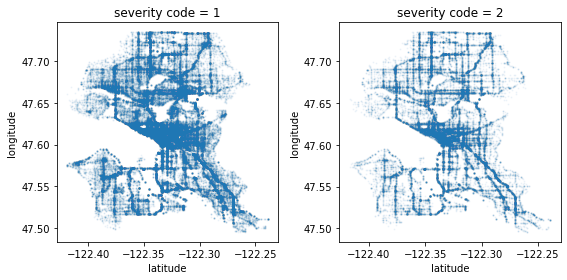

In [584]:
fig, axs = plt.subplots(1,2, figsize=(8,4))
for (ax, (code, d)) in zip(axs, df.groupby('SEVERITYCODE')):
    ax.scatter(d.X, d.Y, s=1, alpha=.05)
    ax.set(xlabel='latitude', ylabel='longitude', title='severity code = {}'.format(code))

plt.tight_layout()
# plt.savefig('images/latitude_longitude_severity_code.png')


Now, let's take a look at some histograms and crunch some numbers for our features.

In [585]:
df[df['COLLISIONTYPE'] == 'Head On']['COLLISIONTYPE'].count()/total_collisions*100

1.0665598701579289

In [586]:
df[df['COLLISIONTYPE'] == 'Parked Car']['COLLISIONTYPE'].count()/total_collisions*100

25.287059530271012

Below you can see a histogram of the collision type. Here you can see that an accident involving a parked car happens 25% of the time in an accident than a head-on collision which is rarer and occurs around 1.0% of the time. 

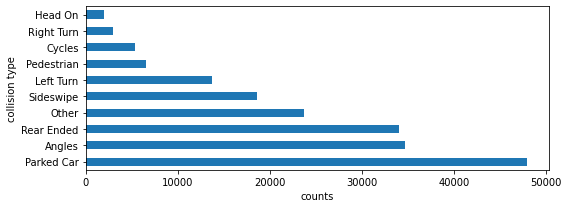

In [587]:
fig, ax = plt.subplots(figsize=(8,3))
df['COLLISIONTYPE'].value_counts().plot.barh(ax=ax)
ax.set(xlabel='counts', ylabel='collision type')
plt.tight_layout()
# plt.savefig('images/collision_type_vs_counts.png')

Below, we look at the junction type and see that non-intersection accidents are most prevelant followed by intersections. 

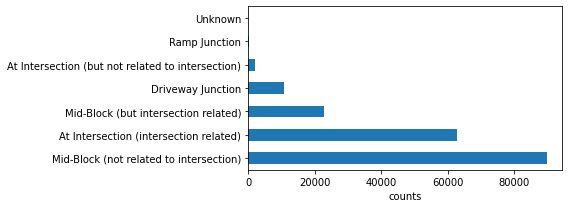

In [588]:
fig, ax = plt.subplots(figsize=(8,3))
df['JUNCTIONTYPE'].value_counts().plot.barh(ax=ax)
ax.set(xlabel='counts', )
plt.tight_layout()
# plt.savefig('images/junctiontype_vs_counts.png')

Corresponding to the plot we just saw, you can see that the address type corresponds to one that occurs on the plot, confirming that the results in the previous plot make sense.

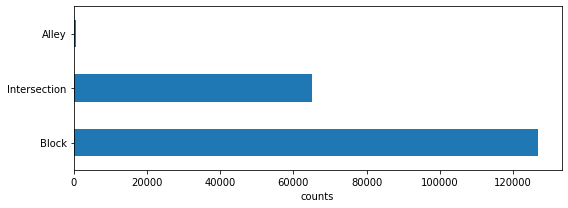

In [589]:
fig, ax = plt.subplots(figsize=(8,3))
df['ADDRTYPE'].value_counts().plot.barh(ax=ax)
ax.set(xlabel='counts', )
plt.tight_layout()
# plt.savefig('images/intersection_vs_counts.png')

Based on the collision type, we can look at what the road conditions are and see why they happened.

In [590]:
df.groupby('COLLISIONTYPE').ROADCOND.unique().reset_index()

,COLLISIONTYPE,ROADCOND
0,Angles,"[Wet, Dry, Snow/Slush, Unknown, Ice, Other, Sa..."
1,Cycles,"[Dry, Wet, Unknown, Ice, Standing Water, Snow/..."
2,Head On,"[Dry, Wet, Snow/Slush, Other, Ice, Unknown, St..."
3,Left Turn,"[Dry, Wet, Unknown, Snow/Slush, Oil, Other, Ic..."
4,Other,"[Dry, Unknown, Wet, Snow/Slush, Ice, Standing ..."
5,Parked Car,"[Dry, Wet, Unknown, nan, Snow/Slush, Ice, Othe..."
6,Pedestrian,"[Dry, Wet, Unknown, nan, Snow/Slush, Other, Ic..."
7,Rear Ended,"[Wet, Dry, Unknown, nan, Snow/Slush, Ice, Sand..."
8,Right Turn,"[Dry, Wet, Unknown, Snow/Slush, Ice, Oil, nan]"
9,Sideswipe,"[Wet, Dry, Unknown, Ice, Snow/Slush, Standing ..."


[Text(0.5, 0, 'counts')]

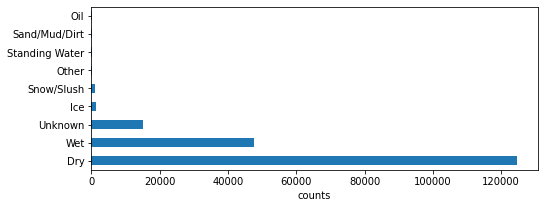

In [591]:
fig, ax = plt.subplots(figsize=(8,3))

ax = df['ROADCOND'].value_counts().plot.barh();
ax.set(xlabel='counts',  )
# plt.savefig('images/roadcondition_vs_counts.png')

In [592]:
df.groupby(['SEVERITYDESC', 'COLLISIONTYPE']).agg(dict(PERSONCOUNT='mean', PEDCOUNT='mean', VEHCOUNT='mean'))


PERSONCOUNT  PEDCOUNT  VEHCOUNT
SEVERITYDESC                   COLLISIONTYPE                                 
Injury Collision               Angles            2.928288  0.004110  2.105769
                               Cycles            2.130481  0.019393  0.973651
                               Head On           2.998853  0.000000  2.194954
                               Left Turn         2.865459  0.003881  2.076880
                               Other             1.996073  0.010798  1.455334
                               Parked Car        2.978963  0.024042  2.509767
                               Pedestrian        2.178235  1.038578  1.014319
                               Rear Ended        3.085202  0.001636  2.306659
                               Right Turn        2.949097  0.008210  2.067323
                               Sideswipe         3.031923  0.007183  2.203512
Property Damage Only Collision Angles            2.571971  0.000190  2.056485
                               Cycles            2.116244  0.008942  1.007452
                               Head On           2.529514  0.000000  2.075521
                               Left Turn         2.599011  0.000121  2.035576
                               Other             1.744585  0.000284  1.442840
                               Parked Car        2.190381  0.000177  2.124699
                               Pedestrian        2.159226  1.029762  1.013393
                               Rear Ended        2.675112  0.000154  2.158299
                               Right Turn        2.654879  0.000000  2.013634
                               Sideswipe         2.557412  0.000000  2.048252

In [593]:
df.groupby('SEVERITYDESC').agg(dict(PERSONCOUNT='mean', PEDCOUNT='mean', VEHCOUNT='mean'))

,PERSONCOUNT,PEDCOUNT,VEHCOUNT
SEVERITYDESC,,,
Injury Collision,2.714357,0.111896,1.867928
Property Damage Only Collision,2.329348,0.005268,1.943312


In [594]:
df[['SEVERITYCODE', 'SEVERITYDESC']].drop_duplicates().sort_values('SEVERITYCODE').style.hide_index()

SEVERITYCODE,SEVERITYDESC
1,Property Damage Only Collision
2,Injury Collision


Below we can see that there is more likely to be a property damage collision than an injury collision.

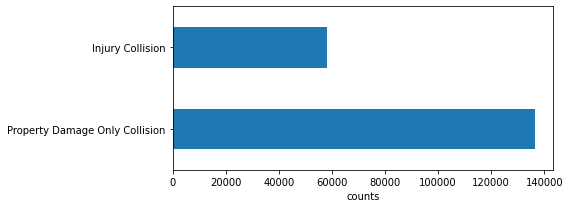

In [595]:
fig, ax = plt.subplots(figsize=(8,3))

ax = df['SEVERITYDESC'].value_counts().plot.barh();
ax.set(xlabel='counts', )
plt.tight_layout()
plt.savefig('images/severitydescription_vs_counts.png')

In [596]:
df['SEVERITYDESC'].value_counts()

Property Damage Only Collision    136485
Injury Collision                   58188
Name: SEVERITYDESC, dtype: int64

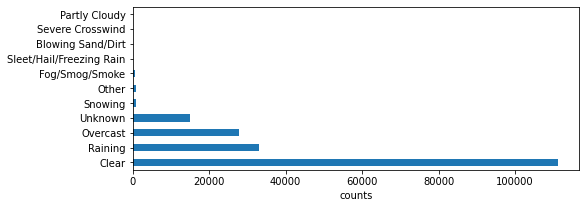

In [597]:
fig, ax = plt.subplots(figsize=(8,3))

ax = df['WEATHER'].value_counts().plot.barh();
ax.set(xlabel='counts', )
plt.savefig('images/weather_vs_counts.png')

[Text(0, 0.5, 'number of vehicles'), Text(0.5, 0, 'counts')]

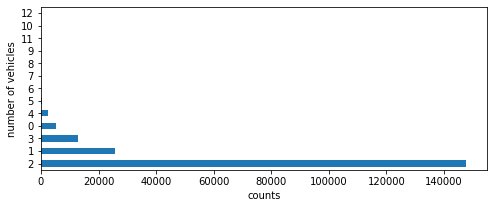

In [598]:
fig, ax = plt.subplots(figsize=(8,3))

ax = df['VEHCOUNT'].value_counts().plot.barh();
ax.set(xlabel='counts', ylabel='number of vehicles' )
# plt.savefig('images/numberofvehicles_vs_counts.png')

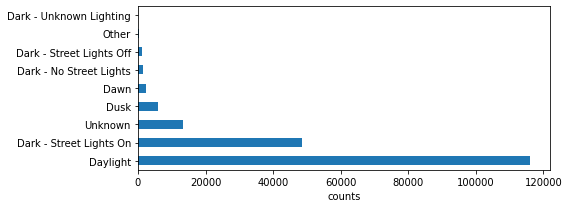

In [600]:
fig, ax = plt.subplots(figsize=(8,3))

ax = df['LIGHTCOND'].value_counts().plot.barh();
ax.set(xlabel='counts',  )
plt.tight_layout()
# plt.savefig('images/lightcondition_vs_counts.png')

[Text(0.5, 0, 'counts')]

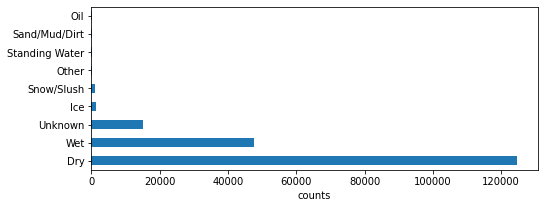

In [601]:
fig, ax = plt.subplots(figsize=(8,3))

ax = df['ROADCOND'].value_counts().plot.barh();
ax.set(xlabel='counts',  )
# plt.savefig('images/roadconditions_vs_counts.png')

<div id='methodology'/>

## Methodology

In this project we will focus our efforts on detecting accident severity by two criterias:

1) Injury Collision

2) Property Damage Only

Now that we've explored the data, we know that there are several features that will be useful in our model. These features are:

* road conditions
* light conditions
* vehicle count 
* weather
* address type
* collision type
* junction type


Our first step is to determine what type of model we want to use. Since we have a binary selection to determine accident severity, we will want to stick with a classifier. So we'll go through using a few models (logistic regression, SCM, and decision tree) to see what gives us the best model.



<div id='analysis'/>

## Analysis

First we'll start with a fresh dataframe that has all the features that we want.

In [603]:
df = df.loc[:,['SEVERITYCODE', 'ROADCOND', 'LIGHTCOND', 'VEHCOUNT', 'WEATHER', 
          'ADDRTYPE', 'COLLISIONTYPE', 'JUNCTIONTYPE']].dropna()
df

,SEVERITYCODE,ROADCOND,LIGHTCOND,VEHCOUNT,WEATHER,ADDRTYPE,COLLISIONTYPE,JUNCTIONTYPE
0,2,Wet,Daylight,2,Overcast,Intersection,Angles,At Intersection (intersection related)
1,1,Wet,Dark - Street Lights On,2,Raining,Block,Sideswipe,Mid-Block (not related to intersection)
2,1,Dry,Daylight,3,Overcast,Block,Parked Car,Mid-Block (not related to intersection)
3,1,Dry,Daylight,3,Clear,Block,Other,Mid-Block (not related to intersection)
4,2,Wet,Daylight,2,Raining,Intersection,Angles,At Intersection (intersection related)
...,...,...,...,...,...,...,...,...
194668,2,Dry,Daylight,2,Clear,Block,Head On,Mid-Block (not related to intersection)
194669,1,Wet,Daylight,2,Raining,Block,Rear Ended,Mid-Block (not related to intersection)
194670,2,Dry,Daylight,2,Clear,Intersection,Left Turn,At Intersection (intersection related)
194671,2,Dry,Dusk,1,Clear,Intersection,Cycles,At Intersection (intersection related)


We can see that a lot of this data is actually not numerical, so we must convert some of these quantities over to numerical values.

Let's take a look at the road conditions column ('ROADCOND') to see what we have. 

In [54]:
df['ROADCOND'].unique().astype('str')

array(['Wet', 'Dry', 'nan', 'Unknown', 'Snow/Slush', 'Ice', 'Other',
       'Sand/Mud/Dirt', 'Standing Water', 'Oil'], dtype='<U14')

There are nans in this columns, so we can count to see how many there are and the cell below states that there are 5012 nans in that columns.

In [605]:
df['LIGHTCOND'].isna().sum(), df['WEATHER'].isna().sum(), df['ADDRTYPE'].isna().sum(), \
df['JUNCTIONTYPE'].isna().sum(), df['COLLISIONTYPE'].isna().sum()

(0, 0, 0, 0, 0)

If you haven't already noticed, there's a lot of catagorical data. So we will need to convert that over to a numerical encoding for future use. Below is all of our categorical data.

In [606]:
df[['ROADCOND', 'LIGHTCOND', 'WEATHER']]

,ROADCOND,LIGHTCOND,WEATHER
0,Wet,Daylight,Overcast
1,Wet,Dark - Street Lights On,Raining
2,Dry,Daylight,Overcast
3,Dry,Daylight,Clear
4,Wet,Daylight,Raining
...,...,...,...
194668,Dry,Daylight,Clear
194669,Wet,Daylight,Raining
194670,Dry,Daylight,Clear
194671,Dry,Dusk,Clear


First we transform the data to a numerical encoding and scale it.

In [680]:
categorical_columns = ['ROADCOND', 'LIGHTCOND', 'WEATHER', 'ADDRTYPE', 'COLLISIONTYPE', 'JUNCTIONTYPE']
numerical_columns = ['VEHCOUNT']
all_columns = categorical_columns + numerical_columns
print('Modeling based on:')
for c in categorical_columns:
    print('* {}: {}'.format(c, df[c].unique()))
for c in numerical_columns:
    print('* {}'.format(c))
#print(', '.join(categorical_columns + numerical_columns))
column_trans = make_column_transformer(
    (OneHotEncoder(handle_unknown='ignore'), categorical_columns), 
    (RobustScaler(), numerical_columns),
)

X = column_trans.fit_transform(df[all_columns])

Modeling based on:
* ROADCOND: ['Wet' 'Dry' 'Unknown' 'Snow/Slush' 'Ice' 'Other' 'Sand/Mud/Dirt'
 'Standing Water' 'Oil']
* LIGHTCOND: ['Daylight' 'Dark - Street Lights On' 'Dark - No Street Lights' 'Unknown'
 'Dusk' 'Dawn' 'Dark - Street Lights Off' 'Other'
 'Dark - Unknown Lighting']
* WEATHER: ['Overcast' 'Raining' 'Clear' 'Unknown' 'Other' 'Snowing' 'Fog/Smog/Smoke'
 'Sleet/Hail/Freezing Rain' 'Blowing Sand/Dirt' 'Severe Crosswind'
 'Partly Cloudy']
* ADDRTYPE: ['Intersection' 'Block' 'Alley']
* COLLISIONTYPE: ['Angles' 'Sideswipe' 'Parked Car' 'Other' 'Cycles' 'Rear Ended' 'Head On'
 'Left Turn' 'Pedestrian' 'Right Turn']
* JUNCTIONTYPE: ['At Intersection (intersection related)'
 'Mid-Block (not related to intersection)' 'Driveway Junction'
 'Mid-Block (but intersection related)'
 'At Intersection (but not related to intersection)' 'Ramp Junction'
 'Unknown']
* VEHCOUNT


In [681]:
X.toarray()

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 1.,  0.,  0., ...,  0.,  0.,  1.],
       ...,
       [ 1.,  0.,  0., ...,  0.,  0.,  0.],
       [ 1.,  0.,  0., ...,  0.,  0., -1.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

In [682]:
X.shape

(182895, 50)

In [683]:
y = np.asarray(df['SEVERITYCODE'])
y[:5]

array([2, 1, 1, 1, 2])

Next we perform the test-train split

In [631]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=0)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (146316, 50) (146316,)
Test set: (36579, 50) (36579,)


Now we will go through the different models. We'll use the training set to perform cross-validation on all of the different models and then we will select the best model from that. 

Roughly in order of priority:
* wrangle model objects and/or yhat arrays in dicts like {'Logistic Regression: [array], 'Random Forest': [array]} so you can run metrics and/or plots (and/or training!) using loops
* ROC (receiver operator characteristic) curve (and ROC AUC (area under curve)) gives a much richer model comparison
* feature_importances_ for tree methods, coefs_ for log reg (but you might need to figure out how to get feature names out of the ColumnTransformer). the array can be handy, but everyone loves a plt.barh
* maybe fit the ColumnTransformer and model together using sklearn.pipeline
* maybe switch from train/test to cross validation
* or maybe enhance the train/test split by using stratified sampling with the target variable (google "sklearn train test stratified")

In [632]:
models = dict([('lr', LogisticRegression(C=0.01, solver='liblinear')), 
               ('dt', DecisionTreeClassifier(criterion="entropy", max_depth = 10)),
               ('rf', ensemble.RandomForestClassifier(n_estimators=100, max_depth=10)),
              ])

In [633]:
for name, model in models.items():
    print('start model = {}'.format(name))
    model.fit(X_train, y_train) 

start model = lr
start model = dt
start model = rf


In [713]:
yhat_dict = dict()
yproba_dict = dict()
for name, model in models.items():
    yhat = model.predict(X_test)
    yhat_dict[name] = yhat
    yproba_dict[name] = model.predict_proba(X_test)[:,1]
    print('classification report for {}'.format(name))
    print(model)
    print(classification_report(y_test, yhat))
    print()
    print()
    print()

classification report for lr
LogisticRegression(C=0.01, solver='liblinear')
              precision    recall  f1-score   support

           1       0.74      0.97      0.84     25317
           2       0.79      0.24      0.37     11262

    accuracy                           0.75     36579
   macro avg       0.76      0.61      0.60     36579
weighted avg       0.76      0.75      0.69     36579




classification report for dt
DecisionTreeClassifier(criterion='entropy', max_depth=10)
              precision    recall  f1-score   support

           1       0.75      0.96      0.84     25317
           2       0.75      0.28      0.40     11262

    accuracy                           0.75     36579
   macro avg       0.75      0.62      0.62     36579
weighted avg       0.75      0.75      0.71     36579




classification report for rf
RandomForestClassifier(max_depth=10)
              precision    recall  f1-score   support

           1       0.74      0.98      0.84     25317
  

Here we can see that there is some overlab in no injury and injury. So we need to change some of our features to make our model better.

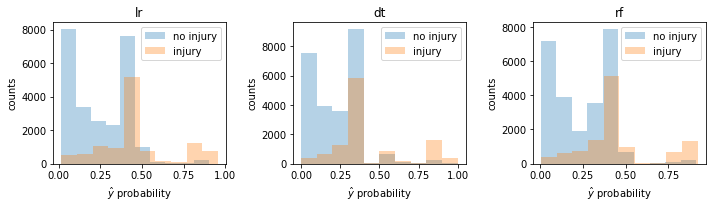

In [635]:
fig, axs = plt.subplots(1,3, figsize=(10, 3))
for ax, name in zip(axs, yproba_dict):
    mask = y_test == 2
    ax.hist(yproba_dict[name][~mask], alpha=.33, label='no injury');
    ax.hist(yproba_dict[name][mask], alpha=.33, label='injury')
    ax.set(xlabel='$\hat{y}$ probability', ylabel='counts', title=name)
    
    ax.legend()
plt.tight_layout()
# plt.savefig('images/counts_vs_yhat_probability.jpeg')

Here we plot an ROC curve to see which models (logistic regression, decision tree, or random forest) does better. It looks like they are all comparable. 

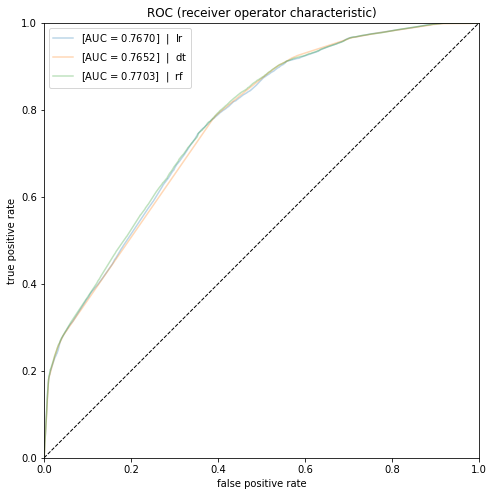

In [710]:
fmt = '[AUC = {:.4f}]  $|$  {}'

fig, ax = plt.subplots(figsize=(8,8))
for name in yproba_dict.keys():
    fp, tp, thresh = metrics.roc_curve(y_test==2, yproba_dict[name])
    label = fmt.format(metrics.auc(fp, tp), name)
    ax.plot(fp, tp, label=label, alpha=.3)
    
lim = [0, 1]
ax.plot(lim, lim, 'k--', lw=1, zorder=-10)
ax.legend()
ax.set(xlim=lim, ylim=lim, aspect='equal', xlabel='false positive rate', ylabel='true positive rate', title='ROC (receiver operator characteristic)');
plt.savefig('images/ROC.jpeg')

Now we want to see which features are the most important for our model to make our predictions better.

In [637]:
def get_column_names_from_ColumnTransformer(column_transformer):    
    col_name = []
    for transformer_in_columns in column_transformer.transformers_[:-1]:
        raw_col_name = transformer_in_columns[2]
        if isinstance(transformer_in_columns[1],Pipeline): 
            transformer = transformer_in_columns[1].steps[-1][1]
        else:
            transformer = transformer_in_columns[1]
        try:
            names = transformer.get_feature_names()
        except AttributeError: 
            names = raw_col_name
        if isinstance(names,np.ndarray): # eg.
            col_name += names.tolist()
        elif isinstance(names,list):
            col_name += names    
        elif isinstance(names,str):
            col_name.append(names)
    return col_name

In [646]:
models['lr'].coef_

(1, 50)

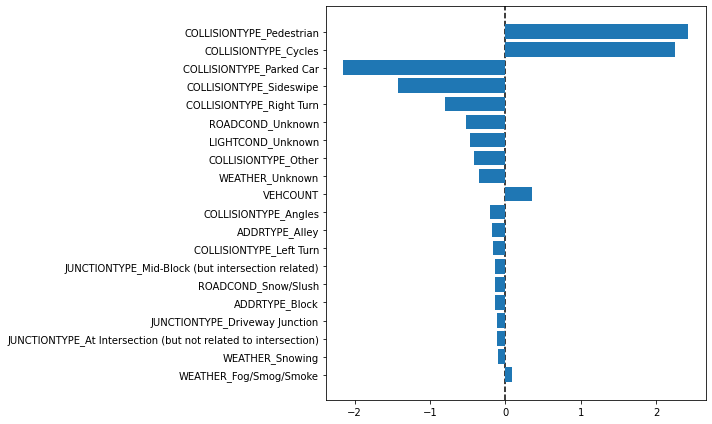

In [652]:
feature_names = get_column_names_from_ColumnTransformer(column_trans)
prefix = {f'x{i}' : v for i,v in enumerate(categorical_columns)}
renamed_features = [prefix[v[:2]] + v[2:] if v[0]=='x' else v for v in feature_names]

imp_names = ['lr']
fig, ax = plt.subplots(figsize=(10, 6))
importance = models['lr'].coef_[0]
d = pd.DataFrame(dict(name=renamed_features, importance=importance, abs_importance=np.abs(importance)))
d = d.sort_values('abs_importance', ascending=True).tail(20)
ax.barh(d.name, d.importance)
ax.axvline(0, color='k', ls='--', zorder=-10)
plt.tight_layout()
plt.savefig('images/lr_feature_importance.jpeg')

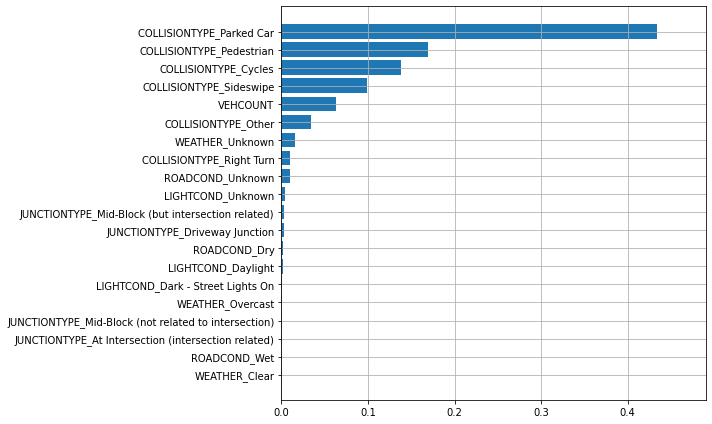

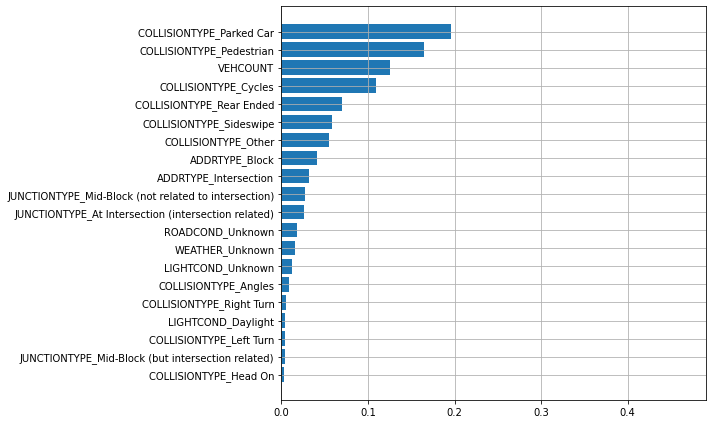

In [659]:
imp_names = ['dt','rf']
for name in imp_names:
    fig, ax = plt.subplots(figsize=(10, 6))
    importance = models[name].feature_importances_
    d = pd.DataFrame(dict(name=renamed_features, importance=importance))
    d = d.sort_values('importance', ascending=True).tail(20)
    ax.barh(d.name, d.importance)
    ax.set(xlim=(0, .49))
    ax.grid()
    plt.tight_layout()
# plt.savefig('images/feature_importance.jpeg')

From this plot it looks like the features that are the most important are the collision type and vehicle count

In [639]:
graph = Source( tree.export_graphviz(models['dt'], out_file=None, feature_names=renamed_features, class_names=['No Injury', 'Injury'], filled=True,  special_characters=True,rotate=False))
graph.format = 'png'
graph.render('images/dtree_render',view=True)

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.962716 to fit


'images/dtree_render.png'

<div id='results'/>

## Results and Discussion

Modeling based on:
* ROADCOND: ['Wet' 'Dry' 'Unknown' 'Snow/Slush' 'Ice' 'Other' 'Sand/Mud/Dirt'
 'Standing Water' 'Oil']
* LIGHTCOND: ['Daylight' 'Dark - Street Lights On' 'Dark - No Street Lights' 'Unknown'
 'Dusk' 'Dawn' 'Dark - Street Lights Off' 'Other'
 'Dark - Unknown Lighting']
* WEATHER: ['Overcast' 'Raining' 'Clear' 'Unknown' 'Other' 'Snowing' 'Fog/Smog/Smoke'
 'Sleet/Hail/Freezing Rain' 'Blowing Sand/Dirt' 'Severe Crosswind'
 'Partly Cloudy']
* ADDRTYPE: ['Intersection' 'Block' 'Alley']
* COLLISIONTYPE: ['Angles' 'Sideswipe' 'Parked Car' 'Other' 'Cycles' 'Rear Ended' 'Head On'
 'Left Turn' 'Pedestrian' 'Right Turn']
* JUNCTIONTYPE: ['At Intersection (intersection related)'
 'Mid-Block (not related to intersection)' 'Driveway Junction'
 'Mid-Block (but intersection related)'
 'At Intersection (but not related to intersection)' 'Ramp Junction'
 'Unknown']
* VEHCOUNT

In [704]:
ex = pd.DataFrame([
    dict(ROADCOND='Wet', 
         LIGHTCOND='Dark - No Street Lights', 
         WEATHER='Fog/Smog/Smoke',
         ADDRTYPE='Intersection',
         COLLISIONTYPE='Pedestrian',
         JUNCTIONTYPE='At Intersection (but not related to intersection)',
         VEHCOUNT=2
        )
])
ex

,ROADCOND,LIGHTCOND,WEATHER,ADDRTYPE,COLLISIONTYPE,JUNCTIONTYPE,VEHCOUNT
0,Wet,Dark - No Street Lights,Fog/Smog/Smoke,Intersection,Pedestrian,At Intersection (but not related to intersection),2


In [714]:
model = models['rf']
model.predict_proba(column_trans.transform(ex))[:,1]

array([0.73289995])

<div id='conclusion'/>

## Conclusion